## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

In [ ]:
DATA_PATH = ""
FIGURE_PATH = ""

ON_TASK_STUDENT  = "XYZ25511"
MIXED_STUDENT    = "XYZ25441"
OFF_TASK_STUDENT = "XYZ25272"

In [ ]:
df = pd.read_csv(DATA_PATH)

df.rename(columns={"readability": "readability_raw"}, inplace=True)
df["readability"] = (df["readability_raw"] < 9).astype(int)
cols = df.columns.tolist()
cols.insert(cols.index("readability_raw") + 1, cols.pop(cols.index("readability")))
df = df.reindex(columns=cols)

df

## Isolate Individual Conversations

In [5]:
df_on_task  = df[df["student"] == ON_TASK_STUDENT].copy()
df_mixed    = df[df["student"] == MIXED_STUDENT].copy()
df_off_task = df[df["student"] == OFF_TASK_STUDENT].copy()

assert set(df_on_task.student)=={ON_TASK_STUDENT}
assert set(df_mixed.student)=={MIXED_STUDENT}
assert set(df_off_task.student)=={OFF_TASK_STUDENT}

assert set(df_on_task["type"])=={"ON_TASK"}
assert set(df_mixed["type"])=={"MIXED"}
assert set(df_off_task["type"])=={"OFF_TASK"}

assert df_on_task.equals(df[df["student"]==ON_TASK_STUDENT])
assert df_mixed.equals(df[df["student"]==MIXED_STUDENT])
assert df_off_task.equals(df[df["student"]==OFF_TASK_STUDENT])

## Generate Figure

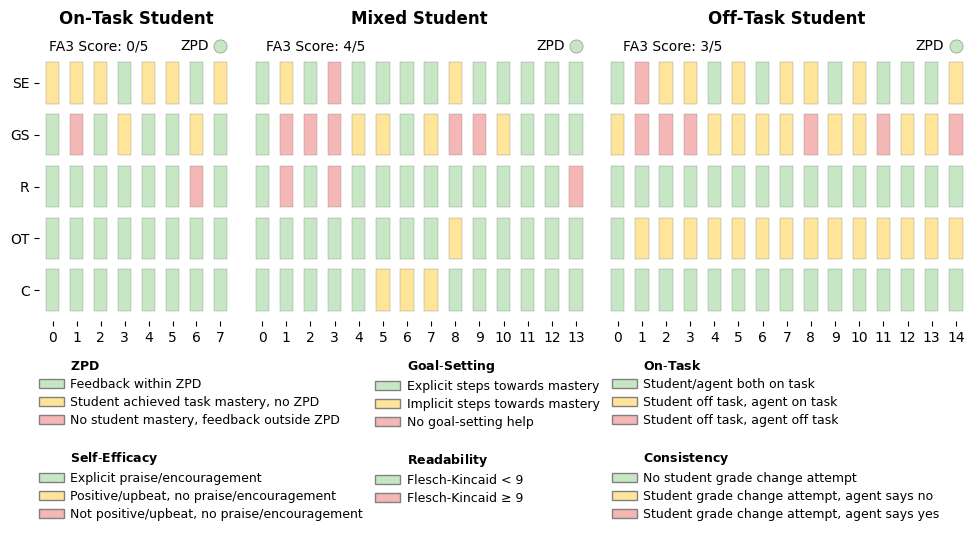

In [6]:
case_dfs = [("On‑Task Student", df_on_task,  "0/5"),
            ("Mixed Student",   df_mixed,    "4/5"),
            ("Off‑Task Student", df_off_task, "3/5")]

constructs = ["self_efficacy","goal_setting","readability",
              "on_task", "consistency"]

ABBREV = {
    "self_efficacy": "SE",
    "goal_setting": "GS",
    "readability": "R",
    "on_task": "OT",
    "consistency": "C"
}

TILE_H  = 0.4
ROW_GAP = 0.50
TILE_W  = 0.05

COLORS = dict(green="#C6E6C4",
              yellow="#FFE599",
              red="#F4B7B5",
              blank="#FFFFFF")

def tile_colour(val, col, is_first):
    if is_first and col in ("on_task", "consistency"):
        return COLORS["green"]
    if pd.isna(val):  return COLORS["blank"]
    if col == "readability":
        return COLORS["green"] if val == 1 else COLORS["red"]
    if col in ("on_task", "consistency"):
        return COLORS[{0:"green", 1:"yellow", -1:"red"}[val]]
    return COLORS[{1:"green", 0:"yellow", -1:"red"}[val]]

case_lengths = [len(df) for _, df, _ in case_dfs]

fig = plt.figure(figsize=(12, 3.5))
gs = gridspec.GridSpec(1, len(case_dfs),
                       width_ratios=case_lengths,
                       figure=fig,
                       wspace=0.05)

axes = [fig.add_subplot(gs[i]) for i in range(len(case_dfs))]

constructs_rev = constructs[::-1]
y_locs = {col: i * ROW_GAP for i, col in enumerate(constructs_rev)}


for ax, (title, df_raw, fa3_str) in zip(axes, case_dfs):
    df = df_raw.copy().reset_index(drop=True)
    spacing_factor = TILE_W * 1.8
    df["agent_idx"] = np.arange(len(df)) * spacing_factor
    xs = df["agent_idx"].to_numpy()

    for col in constructs_rev:
        y_center = y_locs[col]
        for idx, (turn, val) in enumerate(zip(xs, df[col])):
            ax.add_patch(
                plt.Rectangle((turn - TILE_W/2, y_center - TILE_H/2),
                              TILE_W, TILE_H,
                              facecolor=tile_colour(val, col, is_first=(idx == 0)),
                              edgecolor="grey", linewidth=.25)
            )

    ax.set_yticks(list(y_locs.values()))
    if ax == axes[0]:
        ax.set_yticklabels([ABBREV[c] for c in constructs_rev], fontsize=10)
    else:
        ax.set_yticklabels([])
        ax.tick_params(axis='y', left=False)

    ax.set_ylim(-TILE_H/2 - 0.1, max(y_locs.values()) + TILE_H/2 + 0.1)

    ax.set_xticks(xs)
    ax.set_xticklabels(range(len(xs)), fontsize=10)
    ax.set_xlim(xs.min() - TILE_W, xs.max() + TILE_W)

    ax.set_title(title, loc="center", fontweight="bold", pad=20)
    ax.set_frame_on(False)

    zpd_val = df_raw["zpd"].dropna().iloc[0] if not df_raw["zpd"].dropna().empty else np.nan
    zpd_col = {1: COLORS["green"], 0: COLORS["yellow"], -1: COLORS["red"]}.get(zpd_val, COLORS["blank"])
    badge_x, badge_y = 0.95, 1.02

    fa_x = 0.05
    ax.text(fa_x, badge_y, f"FA3 Score: {fa3_str}",
            transform=ax.transAxes,
            fontsize=10, ha="left", va="center")

    if ax is axes[0]:
        badge_x -= 0.02
    elif ax is axes[1]:
        badge_x += 0.01
    else:
        badge_x += 0.0125

    ax.scatter(badge_x, badge_y, transform=ax.transAxes,
              s=90, color=zpd_col, edgecolor="grey", linewidth=.4,
              clip_on=False, zorder=3)

    ax.annotate("ZPD", xy=(badge_x, badge_y), xycoords=ax.transAxes,
              xytext=(-8, 0), textcoords="offset points",
              ha="right", va="center", fontsize=10)

blank = Patch(facecolor="white", edgecolor="white", label="")
legend_handles = [
    Patch(facecolor="white", edgecolor="white", label=r"$\bf{ZPD}$"),
    Patch(facecolor=COLORS["green"], edgecolor="grey", label="Feedback within ZPD"),
    Patch(facecolor=COLORS["yellow"], edgecolor="grey", label="Student achieved task mastery, no ZPD"),
    Patch(facecolor=COLORS["red"], edgecolor="grey", label="No student mastery, feedback outside ZPD"), blank,
    Patch(facecolor="white", edgecolor="white", label=r"$\bf{Self\text{-}Efficacy}$"),
    Patch(facecolor=COLORS["green"], edgecolor="grey", label="Explicit praise/encouragement"),
    Patch(facecolor=COLORS["yellow"],edgecolor="grey", label="Positive/upbeat, no praise/encouragement"),
    Patch(facecolor=COLORS["red"],   edgecolor="grey", label="Not positive/upbeat, no praise/encouragement"), blank,
    Patch(facecolor="white", edgecolor="white", label=r"$\bf{Goal\text{-}Setting}$"),
    Patch(facecolor=COLORS["green"], edgecolor="grey", label="Explicit steps towards mastery"),
    Patch(facecolor=COLORS["yellow"],edgecolor="grey", label="Implicit steps towards mastery"),
    Patch(facecolor=COLORS["red"],   edgecolor="grey", label="No goal-setting help"),blank,
    Patch(facecolor="white", edgecolor="white", label=r"$\bf{Readability}$"),
    Patch(facecolor=COLORS["green"], edgecolor="grey", label="Flesch-Kincaid < 9"),
    Patch(facecolor=COLORS["red"],   edgecolor="grey", label="Flesch-Kincaid ≥ 9"), blank, blank,
    Patch(facecolor="white", edgecolor="white", label=r"$\bf{On\text{-}Task}$"),
    Patch(facecolor=COLORS["green"], edgecolor="grey", label="Student/agent both on task"),
    Patch(facecolor=COLORS["yellow"],edgecolor="grey", label="Student off task, agent on task"),
    Patch(facecolor=COLORS["red"],   edgecolor="grey", label="Student off task, agent off task"), blank,
    Patch(facecolor="white", edgecolor="white", label=r"$\bf{Consistency}$"),
    Patch(facecolor=COLORS["green"], edgecolor="grey", label="No student grade change attempt"),
    Patch(facecolor=COLORS["yellow"],edgecolor="grey", label="Student grade change attempt, agent says no"),
    Patch(facecolor=COLORS["red"],   edgecolor="grey", label="Student grade change attempt, agent says yes")
]

fig.legend(handles=legend_handles,
           loc="lower center",
           bbox_to_anchor=(0.5, -0.55),
           ncol=3,
           frameon=False,
           fontsize=9,
           labelspacing=0.4,
           handletextpad=0.5,
           columnspacing=1.0)

fig.savefig(FIGURE_PATH, dpi=400, bbox_inches="tight",pad_inches=0.1)
plt.show()